In [1]:
import numpy as np
import os 
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler
import warnings
from scipy.ndimage import gaussian_filter
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import SplineTransformer, QuantileTransformer
from scipy import stats
import scipy.stats
import seaborn as sns
import tensorflow as tf
import scipy.io
from tqdm import tqdm
import pickle
import time

In [2]:
import encoding_GLM as glm

In [3]:
print(tf.config.experimental.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from itertools import accumulate
from collections import Counter

def get_data_from_each_CV_fold(train_directory, test_directory, fold):
    directory_train = train_directory.format(fold)
    os.chdir(directory_train)

    behav = scipy.io.loadmat('behav_big_matrix.mat')
    behav_ids = scipy.io.loadmat('behav_big_matrix_ids.mat')

    behav_matrix = behav['behav_big_matrix']
    behav_ids_matrix = behav_ids['behav_big_matrix_ids'][0]

    response = scipy.io.loadmat('combined_response.mat')
    response_matrix = response['combined_response']
    response_matrix[response_matrix > 0.05] = 1

    X_train = behav_matrix
    Y_train = response_matrix
    
    behav_IDS = []
    for trial in list(range(behav_ids['behav_big_matrix_ids'][0].shape[0])):
        behav_IDS.append(behav_ids['behav_big_matrix_ids'][0][trial][0])

    # Count the occurrences of each element in the list
    counter = Counter(behav_IDS)

    # Get the unique values
    unique_values = list(counter.keys())

    # Get the count of each unique value
    count_of_values = list(counter.values())

    IDS_index = np.array(list(accumulate(count_of_values)))-1
    IDS_for_count_of_values = []
    for index in IDS_index[0:418]:
        IDS_for_count_of_values.append(behav_IDS[index])
        
    directory_test = test_directory.format(fold)
    os.chdir(directory_test)

    behav = scipy.io.loadmat('behav_big_matrix.mat')
    behav_ids = scipy.io.loadmat('behav_big_matrix_ids.mat')

    behav_matrix = behav['behav_big_matrix']
    behav_ids_matrix = behav_ids['behav_big_matrix_ids'][0]

    response = scipy.io.loadmat('combined_response.mat')
    response_matrix = response['combined_response']
    response_matrix[response_matrix > 0.05] = 1

    X_test = behav_matrix
    Y_test = response_matrix
    
    # Clean up design matrix and z-score along sample dimension
    X_train = X_train.T
    # Multiply deconvolved activity by 10 to mimic spike number
    Y_train = 10 * Y_train.T

    X_test = X_test.T
    # Multiply deconvolved activity by 10 to mimic spike number
    Y_test = 10 * Y_test.T
    
    return X_train, Y_train, X_test, Y_test, count_of_values, IDS_for_count_of_values

In [5]:
def train_model_on_cv_fold(X_train, Y_train, count_of_values):
    # Reset keras states
    tf.keras.backend.clear_session()

    model = glm.GLM(activation = 'exp', loss_type = 'poisson', 
                    regularization = 'elastic_net', lambda_series = 10.0 ** np.linspace(-1, -8, 10), 
                    l1_ratio = 0.98, smooth_strength = 0., 
                    optimizer = 'adam', learning_rate = 1e-3)
    
    model.fit(X_train, Y_train, feature_group_size = count_of_values, verbose = False) 
    
    return model

def train_model_on_cv_fold_GPU(X_train, Y_train, count_of_values):
    # Ensure the function runs on GPU
    with tf.device('/GPU:0'):
        # Reset keras states
        tf.keras.backend.clear_session()

        model = glm.GLM(activation = 'exp', loss_type = 'poisson', 
                        regularization = 'elastic_net', lambda_series = 10.0 ** np.linspace(-1, -8, 10), 
                        l1_ratio = 0.98, smooth_strength = 0., 
                        optimizer = 'adam', learning_rate = 1e-3)
        # Capture the start time
        start_time = time.time()
        
        # Fit the model
        model.fit(X_train, Y_train, feature_group_size=count_of_values, verbose=False) 
        
        # Capture the end time
        end_time = time.time()

    print(f"Time taken on GPU: {end_time - start_time:.4f} seconds")
    
    return model


In [41]:
for dataset in ['PPC B67 0629']:
    directory = "/Volumes/Runyan2/Akhil/Runyan-Piasini-2017-master/Data/{}/all_state_model".format(dataset) 
    frac_dev_expl_all = []
    for fold_number in list(range(0,1)):
        train_directory = directory + "/prepost trial cv 73 #{}".format(fold_number+1)
        test_directory = directory + "/prepost trial cv 73 #{}/test".format(fold_number+1)

        for i in tqdm(range(5)):
            [X_train, Y_train, X_test, Y_test, count_of_values, IDS_for_count_of_values] = get_data_from_each_CV_fold(train_directory,
                                                                                                                      test_directory,
                                                                                                                      fold_number+1)

100%|██████████| 5/5 [00:01<00:00,  4.05it/s]


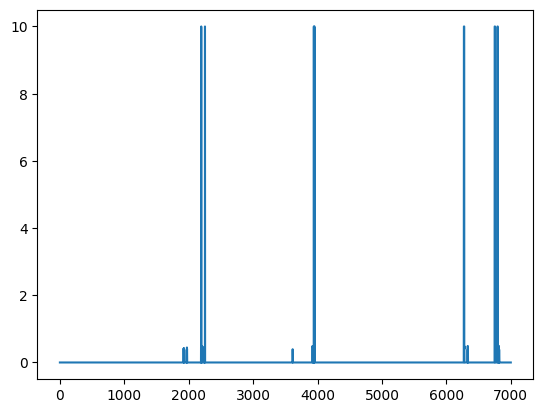

In [42]:
plt.plot(Y_test[:,0])

In [14]:
def open_pkl_file(file_location):
    with open(file_location, 'rb') as file:
        data = pickle.load(file)
        
    # Assuming the loaded data is a dictionary
    #if isinstance(data, dict):
    #    print("Keys in the .pkl file:", data.keys())
    #else:
    #    print("The loaded data is not a dictionary.")

    return data 

In [37]:
file_loc = '/Volumes/Runyan2/Akhil/Runyan-Piasini-2017-master/Data/PPC B67 0629/all_state_model/prepost trial cv 73 #1/model_data_a95.pkl'
x = open_pkl_file(file_loc)

In [38]:
x.keys()

dict_keys(['frac_dev_expl', 'dev_model', 'dev_null', 'dev_expl', 'B_weights', 'intercept_weight', 'y_pred', 'selec_lambda'])

In [39]:
pred = x['y_pred']

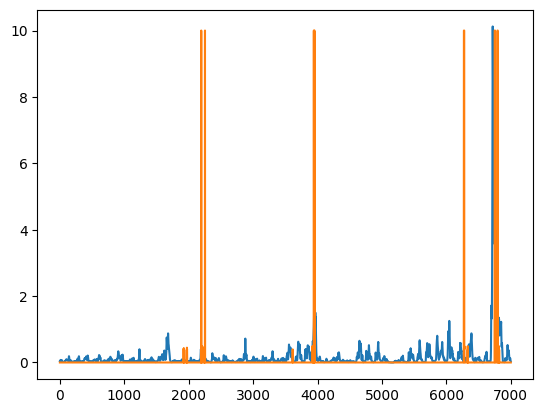

In [44]:
plt.plot(pred[:, 0])
plt.plot(Y_test[:, 0])

In [7]:
for dataset in ['PPC B67 0629', 'PPC B67 0716', 'PPC B68 0628', 'PPC B68 0630', 'PPC B68 0703', 'PPC B77 0828', 
                'A1 B67 0703', 'A1 B68 0702', 'A1 B75 0908','A1 B77 0905']:
    directory = "/Volumes/Runyan2/Akhil/Runyan-Piasini-2017-master/Data/{}/all_state_model".format(dataset) 
    frac_dev_expl_all = []
    for fold_number in list(range(0,10)):
        train_directory = directory + "/prepost trial cv 73 #{}".format(fold_number+1)
        test_directory = directory + "/prepost trial cv 73 #{}/test".format(fold_number+1)

        for i in tqdm(range(5)):
            [X_train, Y_train, X_test, Y_test, count_of_values, IDS_for_count_of_values] = get_data_from_each_CV_fold(train_directory,
                                                                                                                      test_directory,
                                                                                                                      fold_number+1)
        model_trained = train_model_on_cv_fold_GPU(X_train, Y_train, count_of_values)
        model_trained.select_model(X_test, Y_test, min_lambda = 0.0, make_fig = False)
        frac_dev_expl, dev_model, dev_null, dev_expl = model_trained.evaluate(X_test, Y_test, make_fig = False)
        B_weights = model_trained.selected_w
        intercept_weight = model_trained.selected_w0
        y_pred = model_trained.predict(X_test)
        selec_lambda = model_trained.selected_lambda
        
        model_data = {
            'frac_dev_expl': frac_dev_expl,
            'dev_model': dev_model,
            'dev_null': dev_null, 
            'dev_expl': dev_expl, 
            'B_weights': B_weights,
            'intercept_weight': intercept_weight,
            'y_pred': y_pred,
            'selec_lambda': selec_lambda
        }
        
        os.chdir(train_directory)

        with open('model_data_a95_GPU.pkl', 'wb') as file:
            pickle.dump(model_data, file)
            
        frac_dev_expl_all.append(model_data['frac_dev_expl'])
    
    frac_dev_expl_all_state1 = np.array(frac_dev_expl_all, dtype=object)
    save_directory = "/Volumes/Runyan2/Akhil/Runyan-Piasini-2017-master/Data/{}".format(dataset)
    os.chdir(save_directory)
    np.save('performance_allstate_a98_GPU.npy', frac_dev_expl_all_state1)
    print(dataset + ' - DONE')

100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


Time taken on GPU: 286.9554 seconds
Fraction deviance explained: mean = 0.1284, median = 0.0691


100%|██████████| 5/5 [00:01<00:00,  3.51it/s]


Time taken on GPU: 287.4806 seconds
Fraction deviance explained: mean = -0.0167, median = 0.0779


100%|██████████| 5/5 [00:01<00:00,  3.37it/s]


Time taken on GPU: 297.6849 seconds
Fraction deviance explained: mean = 0.1052, median = 0.0946


100%|██████████| 5/5 [00:01<00:00,  3.50it/s]


Time taken on GPU: 294.9658 seconds
Fraction deviance explained: mean = 0.1232, median = 0.0984


100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


Time taken on GPU: 295.8243 seconds
Fraction deviance explained: mean = 0.0998, median = 0.0830


100%|██████████| 5/5 [00:01<00:00,  3.46it/s]


Time taken on GPU: 292.6690 seconds
Fraction deviance explained: mean = 0.0422, median = 0.0774


100%|██████████| 5/5 [00:01<00:00,  3.30it/s]


Time taken on GPU: 295.3190 seconds
Fraction deviance explained: mean = 0.0861, median = 0.0851


100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


Time taken on GPU: 291.9354 seconds
Fraction deviance explained: mean = 0.1281, median = 0.0666


100%|██████████| 5/5 [00:01<00:00,  3.41it/s]


Time taken on GPU: 288.7541 seconds
Fraction deviance explained: mean = -0.4332, median = 0.1213


100%|██████████| 5/5 [00:01<00:00,  3.19it/s]


Time taken on GPU: 291.3702 seconds
Fraction deviance explained: mean = 0.0362, median = 0.0785
PPC B67 0629 - DONE


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Time taken on GPU: 327.7309 seconds
Fraction deviance explained: mean = -30161087250954246755720443153350656.0000, median = 0.0372


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Time taken on GPU: 317.1392 seconds
Fraction deviance explained: mean = -32522987000819110703585246807326720.0000, median = 0.0323


100%|██████████| 5/5 [00:02<00:00,  2.04it/s]


Time taken on GPU: 315.6177 seconds
Fraction deviance explained: mean = -31450128066247761929160269473251328.0000, median = 0.0371


100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


Time taken on GPU: 319.9890 seconds
Fraction deviance explained: mean = -36275607283922381606649863767851008.0000, median = 0.0217


100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Time taken on GPU: 335.2593 seconds
Fraction deviance explained: mean = -27126674915556564711086506242998272.0000, median = 0.0438


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Time taken on GPU: 310.8416 seconds
Fraction deviance explained: mean = -34199125276264644892444617493970944.0000, median = 0.0249


100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


Time taken on GPU: 312.9382 seconds
Fraction deviance explained: mean = -34212121811102314563438026132815872.0000, median = 0.0207


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


Time taken on GPU: 312.0239 seconds
Fraction deviance explained: mean = -33595200198110976798936964316266496.0000, median = 0.0248


100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


Time taken on GPU: 317.7087 seconds
Fraction deviance explained: mean = -33342511055282388828970069620948992.0000, median = 0.0205


100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Time taken on GPU: 340.4951 seconds
Fraction deviance explained: mean = -27266501245833570185172130281291776.0000, median = 0.0395
PPC B67 0716 - DONE


100%|██████████| 5/5 [00:02<00:00,  2.45it/s]


Time taken on GPU: 310.6081 seconds
Fraction deviance explained: mean = 0.0753, median = 0.0630


100%|██████████| 5/5 [00:02<00:00,  2.47it/s]


Time taken on GPU: 304.6901 seconds
Fraction deviance explained: mean = 0.0792, median = 0.0682


100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Time taken on GPU: 306.1844 seconds
Fraction deviance explained: mean = 0.0729, median = 0.0602


100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


Time taken on GPU: 310.9153 seconds
Fraction deviance explained: mean = 0.0642, median = 0.0478


100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


Time taken on GPU: 305.8776 seconds
Fraction deviance explained: mean = 0.0692, median = 0.0540


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Time taken on GPU: 1576.9937 seconds
Fraction deviance explained: mean = 0.0542, median = 0.0394


100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Time taken on GPU: 2429.7834 seconds
Fraction deviance explained: mean = 0.0593, median = 0.0469


100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Time taken on GPU: 511.3241 seconds
Fraction deviance explained: mean = 0.0558, median = 0.0472


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Time taken on GPU: 309.5322 seconds
Fraction deviance explained: mean = 0.0518, median = 0.0411


100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Time taken on GPU: 300.0782 seconds
Fraction deviance explained: mean = 0.0515, median = 0.0620
PPC B68 0628 - DONE


100%|██████████| 5/5 [00:02<00:00,  2.44it/s]


Time taken on GPU: 284.0000 seconds
Fraction deviance explained: mean = -41213837531419711208651736005738496.0000, median = 0.0418


100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


Time taken on GPU: 286.2869 seconds
Fraction deviance explained: mean = -42115351491753089857277543908900864.0000, median = 0.0183


100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


Time taken on GPU: 280.9688 seconds
Fraction deviance explained: mean = -41330723687259012785946429862445056.0000, median = 0.0478


100%|██████████| 5/5 [00:02<00:00,  2.43it/s]


Time taken on GPU: 278.1439 seconds
Fraction deviance explained: mean = -43153733732451691610259675672477696.0000, median = 0.0417


100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


Time taken on GPU: 283.9657 seconds
Fraction deviance explained: mean = -40833010590709319575442933021671424.0000, median = 0.0316


100%|██████████| 5/5 [00:02<00:00,  2.41it/s]


Time taken on GPU: 283.5490 seconds
Fraction deviance explained: mean = -36402581683174104712548470872866816.0000, median = 0.0310


100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


Time taken on GPU: 278.7511 seconds
Fraction deviance explained: mean = -41088114919585839956732073138454528.0000, median = 0.0337


100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Time taken on GPU: 283.7573 seconds
Fraction deviance explained: mean = -37130307199808838990625043621347328.0000, median = 0.0459


100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


Time taken on GPU: 281.6790 seconds
Fraction deviance explained: mean = -43002115686532928438448860579233792.0000, median = 0.0397


100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Time taken on GPU: 272.7216 seconds
Fraction deviance explained: mean = -42768149982643821478279291921760256.0000, median = 0.0635
PPC B68 0630 - DONE


100%|██████████| 5/5 [00:01<00:00,  3.86it/s]


Time taken on GPU: 323.7972 seconds
Fraction deviance explained: mean = 0.0323, median = 0.0193


100%|██████████| 5/5 [00:01<00:00,  4.05it/s]


Time taken on GPU: 335.1769 seconds
Fraction deviance explained: mean = 0.0295, median = 0.0062


100%|██████████| 5/5 [00:01<00:00,  4.21it/s]


Time taken on GPU: 333.7824 seconds
Fraction deviance explained: mean = 0.0363, median = 0.0266


100%|██████████| 5/5 [00:01<00:00,  3.83it/s]


Time taken on GPU: 337.5923 seconds
Fraction deviance explained: mean = 0.0256, median = 0.0116


100%|██████████| 5/5 [00:01<00:00,  4.00it/s]


Time taken on GPU: 336.4201 seconds
Fraction deviance explained: mean = 0.0256, median = 0.0161


100%|██████████| 5/5 [00:01<00:00,  4.15it/s]


Time taken on GPU: 329.2054 seconds
Fraction deviance explained: mean = 0.0306, median = 0.0108


100%|██████████| 5/5 [00:01<00:00,  4.25it/s]


Time taken on GPU: 342.0205 seconds
Fraction deviance explained: mean = 0.0356, median = 0.0227


100%|██████████| 5/5 [00:01<00:00,  4.08it/s]


Time taken on GPU: 332.6380 seconds
Fraction deviance explained: mean = 0.0104, median = 0.0176


100%|██████████| 5/5 [00:01<00:00,  4.08it/s]


Time taken on GPU: 340.0443 seconds
Fraction deviance explained: mean = 0.0452, median = 0.0172


100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Time taken on GPU: 332.4489 seconds
Fraction deviance explained: mean = 0.0319, median = 0.0221
PPC B68 0703 - DONE


100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


Time taken on GPU: 324.4838 seconds
Fraction deviance explained: mean = 0.1249, median = 0.1074


100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


Time taken on GPU: 320.0565 seconds
Fraction deviance explained: mean = 0.1399, median = 0.1105


100%|██████████| 5/5 [00:01<00:00,  2.98it/s]


Time taken on GPU: 317.8287 seconds
Fraction deviance explained: mean = 0.1253, median = 0.1212


100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


Time taken on GPU: 317.1050 seconds
Fraction deviance explained: mean = 0.1638, median = 0.1353


100%|██████████| 5/5 [00:01<00:00,  2.86it/s]


Time taken on GPU: 1290.8007 seconds
Fraction deviance explained: mean = 0.1417, median = 0.1139


100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


Time taken on GPU: 1223.7190 seconds
Fraction deviance explained: mean = 0.1247, median = 0.0950


100%|██████████| 5/5 [00:01<00:00,  2.90it/s]


Time taken on GPU: 2182.9667 seconds
Fraction deviance explained: mean = 0.1383, median = 0.1139


100%|██████████| 5/5 [00:02<00:00,  2.48it/s]


Time taken on GPU: 1242.5607 seconds
Fraction deviance explained: mean = 0.1258, median = 0.1169


100%|██████████| 5/5 [00:01<00:00,  2.95it/s]


Time taken on GPU: 2169.6102 seconds
Fraction deviance explained: mean = 0.1302, median = 0.0978


100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Time taken on GPU: 2151.9247 seconds
Fraction deviance explained: mean = 0.0932, median = 0.0714
PPC B77 0828 - DONE


100%|██████████| 5/5 [00:01<00:00,  4.32it/s]


Time taken on GPU: 1311.6101 seconds
Fraction deviance explained: mean = 0.0916, median = 0.0606


100%|██████████| 5/5 [00:01<00:00,  4.59it/s]


Time taken on GPU: 3185.5512 seconds
Fraction deviance explained: mean = 0.0901, median = 0.0659


100%|██████████| 5/5 [00:01<00:00,  4.58it/s]


Time taken on GPU: 643.8772 seconds
Fraction deviance explained: mean = 0.1009, median = 0.0839


100%|██████████| 5/5 [00:01<00:00,  4.58it/s]


Time taken on GPU: 3156.7451 seconds
Fraction deviance explained: mean = 0.0791, median = 0.0628


100%|██████████| 5/5 [00:01<00:00,  4.68it/s]


Time taken on GPU: 1507.1877 seconds
Fraction deviance explained: mean = 0.0893, median = 0.0639


100%|██████████| 5/5 [00:01<00:00,  4.68it/s]


Time taken on GPU: 2621.3852 seconds
Fraction deviance explained: mean = 0.0845, median = 0.0726


100%|██████████| 5/5 [00:01<00:00,  4.61it/s]


Time taken on GPU: 2242.9589 seconds
Fraction deviance explained: mean = 0.0912, median = 0.0700


100%|██████████| 5/5 [00:01<00:00,  4.79it/s]


Time taken on GPU: 1496.9341 seconds
Fraction deviance explained: mean = 0.0804, median = 0.0561


100%|██████████| 5/5 [00:01<00:00,  4.63it/s]


Time taken on GPU: 590.1405 seconds
Fraction deviance explained: mean = 0.0769, median = 0.0576


100%|██████████| 5/5 [00:02<00:00,  2.07it/s]


Time taken on GPU: 2295.5471 seconds
Fraction deviance explained: mean = 0.1072, median = 0.1095
A1 B67 0703 - DONE


100%|██████████| 5/5 [00:01<00:00,  3.78it/s]


Time taken on GPU: 1643.6767 seconds
Fraction deviance explained: mean = 0.0873, median = 0.0598


100%|██████████| 5/5 [00:01<00:00,  3.95it/s]


Time taken on GPU: 2204.4313 seconds
Fraction deviance explained: mean = 0.0980, median = 0.0682


100%|██████████| 5/5 [00:01<00:00,  3.85it/s]


Time taken on GPU: 2227.0323 seconds
Fraction deviance explained: mean = 0.0956, median = 0.0657


100%|██████████| 5/5 [00:01<00:00,  3.95it/s]


Time taken on GPU: 2210.5935 seconds
Fraction deviance explained: mean = 0.1004, median = 0.0628


100%|██████████| 5/5 [00:01<00:00,  3.94it/s]


Time taken on GPU: 2173.5000 seconds
Fraction deviance explained: mean = 0.0674, median = 0.0282


100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


Time taken on GPU: 2172.8971 seconds
Fraction deviance explained: mean = 0.0895, median = 0.0503


100%|██████████| 5/5 [00:01<00:00,  3.80it/s]


Time taken on GPU: 2042.7000 seconds
Fraction deviance explained: mean = 0.0923, median = 0.0541


100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


Time taken on GPU: 2193.0272 seconds
Fraction deviance explained: mean = 0.0863, median = 0.0526


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


Time taken on GPU: 2148.2426 seconds
Fraction deviance explained: mean = 0.1062, median = 0.0893


100%|██████████| 5/5 [00:01<00:00,  3.81it/s]


Time taken on GPU: 1276.4902 seconds
Fraction deviance explained: mean = 0.1039, median = 0.0490
A1 B68 0702 - DONE


100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


Time taken on GPU: 2716.0970 seconds
Fraction deviance explained: mean = 0.0812, median = 0.0602


100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


Time taken on GPU: 2207.9797 seconds
Fraction deviance explained: mean = 0.0879, median = 0.0492


100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


Time taken on GPU: 529.5154 seconds
Fraction deviance explained: mean = 0.0968, median = 0.0487


100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


Time taken on GPU: 2272.7058 seconds
Fraction deviance explained: mean = 0.0739, median = 0.0322


100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


Time taken on GPU: 2207.6090 seconds
Fraction deviance explained: mean = 0.0795, median = 0.0475


100%|██████████| 5/5 [00:02<00:00,  2.20it/s]


Time taken on GPU: 2182.1687 seconds
Fraction deviance explained: mean = 0.0726, median = 0.0518


100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


KeyboardInterrupt: 